# COSC440 Project Part 1: Building a Convolutional Autoencoder

In the first part of the project, we will be introducing and getting familiar with the concept of convolutional autoencoders. In the second part we will apply this model to a domain problem data set. In the final part you will extend the model to address a subproblem in the area of your choice.

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.


![Autoencoders](https://drive.google.com/uc?export=view&id=18iU9_yZfqs2QlTPbaibzkMtdIekLuPj2)

As we can see, the autoencoder is divided roughly in two parts: the encoder that encodes the input to a "code", or internal representation, that is reduced in dimensions, and the decoder that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function h(x)≈x. In other words, it is trying to learn an approximation to the identity function, so as to output x'  that is similar to x. This may sound like a pretty trivial task, why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### In this part, we will be building a denoising autoencoder. The input of the autoencoder will be a noisy version of our training data and we will train the model to predict the noise free version. 

## Deconvolution (Transposed-Convolution)
Conceptually, deconvolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while deconvolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2 *going from bigger to smaller*:
![convolution.gif](https://drive.google.com/uc?export=view&id=1TjSgMinNQ629TrdEmcVjKuwWZ9MGMfg7)

#### Deconvolution (convolution with fractional stride) *going from smaller to bigger*:
![deconvolution.gif](https://drive.google.com/uc?export=view&id=1opzIaiShA5_nLT5Y5Kh_GqPT9IlVeQF5)

As we can see, deconvolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.
Concretely, this is how we implement deconvolution in tensorflow:

``` Python
tf.nn.conv2d_transpose(
    value, # input tensor: A 4-D Tensor of type float and shape [batch, height, width, in_channels]
    filter, # filter tensor: A 4-D Tensor with shape [height, width, output_channels, in_channels]
    output_shape, # A 1-D Tensor representing the output shape of the deconvolution op.
    strides, # A list of ints. The stride of the sliding window for each dimension of the input tensor.
    padding='SAME'
)
```

## Setup

Enabling the GPU:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [6]:
# This makes sure that we are using Tensorflow 2
try:
  # Note: %tensorflow_version only exists in Google Colab
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2.6.0
GPU Available:  []


If set up correctly, you should see "GPU Available: True" in the output.

### Noise Functions

In order to test our autoencoder, we need to add some noise to our MNIST data points. The goal for the autoencoder is to learn the important underlying features (the numbers) of the data and to ignore the extra noise. 

Implement the below different noise functions.

In [7]:
"""
This function adds no noise, we use this as a way of comparing the 
autoencoder when there's no input noise
"""
def no_noise(x):
  x = tf.dtypes.cast(x, tf.float32)
  return x

"""
This function should add a random uniform tensor of the shape of x between 
-0.3 to 0.3 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_noise(x):
  x = tf.dtypes.cast(x, tf.float32)
  noised = x + tf.random.uniform(x.shape, minval=-0.3, maxval=0.3)
  return tf.clip_by_value(noised, 0, 1)

"""
This function should multiply a random uniform tensor of the shape of x between 
0 to 2.0 to x. 

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_scale(x):
  x_float = tf.dtypes.cast(x, tf.float32)
  noised = tf.math.multiply(x_float, tf.random.uniform(x_float.shape, minval=0.0, maxval=2.0))
  return tf.clip_by_value(noised, 0, 1)

# some "unit tests"
x = [[0.3,0.1],[0.2,0]]
y = [[0.1,1],[0,0.33]]
result_1 = random_noise(x)
result_2 = random_scale(x)
result_3 = random_noise(y)
result_4 = random_scale(y)

for res in [result_1, result_2, result_3, result_4]:
  assert(res.shape == (2,2))
  assert(res.dtype == tf.float32)
  assert(np.max(np.array(res)) <= 1.0)
  assert(np.min(np.array(res)) >= 0.0)

print("Noise functions look good!")

Noise functions look good!


## Architecture Definition
We want to construct the following architecture:

(Due to the limitations of the rendering engine I'm using, there is a small inaccuracy: the connections in the decoder *{the red prisms}* should be upscaling, not downscaling like in the encoder. - original creator of lab)

Shapes:

Layer | Shape of Output
--- | ---
Input | (batch_size, 28, 28, 1)
encoder_conv_1    | (batch_size, 14, 14, 10)
encoder_conv_2    | (batch_size, 7, 7, 10)  
encoder_conv_3    | (batch_size, 4, 4, 10)  
decoder_deconv_1  | (batch_size, 7, 7, 10)  
decoder_deconv_2  | (batch_size, 14, 14, 10)
decoder_deconv_3  | (batch_size, 28, 28, 1)

![Architecture](https://drive.google.com/uc?export=view&id=1GaQ-xZ0lmU8iNTm1IVPo60NyKUAyB9bx)

### **Encoder**
Let's first build the encoding portion of our autoencoder. We're going to directly use Keras layers to help us out by subclassing the Layer class. See this for more information on subclassing Layers: https://www.tensorflow.org/guide/keras/custom_layers_and_models

This should have 3 convolution layers. The layers should be initialized with random normal with standard deviation of 0.1. Also, please use an activation layer of leaky_relu with alpha=0.2. Use a kernel size of 3 and padding of same. Think about what the filter count and stride should be by looking at the output shapes of the architecture.

In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
       super(Encoder, self).__init__()
       initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
       self.encoder_conv_1 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
       self.encoder_conv_2 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
       self.encoder_conv_3 = tf.keras.layers.Conv2D(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
    
    @tf.function
    def call(self, images):
        for layer in [self.encoder_conv_1, self.encoder_conv_2, self.encoder_conv_3]:
            images = layer(images)
            images = tf.nn.leaky_relu(images, 0.2)
        return images

### **Decoder**
Now let's build the decoder portion of our autoencoder.

This should have 3 deconvolution layers. For the first deconvolution layer please use tf.nn.conv2d_transpose to implement the deconvolution. The other two may be keras layers (Conv2DTranspose). Use the same kernel / activation /initialization as the encoder.

In [9]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
        
        self.L1_W = tf.Variable(tf.random.normal([4, 4, 10, 10], dtype=tf.float32, stddev=0.1))
        self.L1_b = tf.Variable(tf.random.truncated_normal([1, 7, 7, 10], dtype=tf.float32, stddev=0.1))

        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(10, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(1, 3, (2, 2), 'same', kernel_initializer=initializer, bias_initializer=initializer)
        
    @tf.function
    def call(self, encoder_output):
        output_shape = (encoder_output.shape[0], 7, 7, 10)

        deconv_1 = tf.nn.conv2d_transpose(encoder_output, self.L1_W, output_shape, 2)
        deconv_1_with_bias = tf.add(deconv_1, self.L1_b)
        deconv_1_activated = tf.nn.leaky_relu(deconv_1_with_bias, alpha=0.2)
        
        deconv_2 = self.decoder_deconv_2(deconv_1_activated)
        deconv_2_activated = tf.nn.leaky_relu(deconv_2, alpha=0.2)

        deconv_3 = self.decoder_deconv_3(deconv_2_activated)
        deconv_3_activated = tf.nn.leaky_relu(deconv_3, alpha=0.2)

        return deconv_3_activated

Now let's combine everything to create our autoencoder.

Fill in the call and loss_function.

Our loss equation is:
$$\sum (y - x)^2$$


y: the encoded image 

x: the original corrupted image (note: **NOT** the original uncorrupted image -- in general it is acceptable to train against the uncorrupted image but that makes an assumption we do not have in the second part of the project, namely that it requires clean images and that the systemic/instrument noise in real data matches the simulated noise function of the training otherwise the trained network risks injecting bias towards the trained noise pattern)

In [10]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @tf.function
    def call(self, images):
        z = self.encoder.call(images)
        return self.decoder.call(z)
    
    @tf.function
    def loss_function(self, encoded, originals):
      encoded = tf.dtypes.cast(encoded, tf.float32)
      originals = tf.dtypes.cast(originals, tf.float32)
      return tf.math.reduce_sum(tf.math.square(encoded - originals))

### Train Loop
Next, please fill in the train loop for training.  

In [11]:
def train(model: AutoEncoder, optimizer, images, noise_function):
  corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
  
  with tf.GradientTape() as tape:
    encoded = model.call(corrupted)
    loss = model.loss_function(encoded, corrupted)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Total Loss
This function that calculates the total loss over the entire data set, 
we use this to track the loss over each epoch

In [12]:
def total_loss(model, images, noise_function):
  sum_loss = 0
  corrupted = tf.reshape(noise_function(images), [-1, 28, 28, 1])
  predictions = model(corrupted)
  sum_loss += model.loss_function(predictions, corrupted).numpy()
  return sum_loss

## Test your autoencoder

Run the following code to run your autoencoder. You should see it print out images and the total loss of the autoencoder each epoch.

Be aware that the loss generally should go down each epoch, but might not always. Use your judgement and check with the TA after this runs.

It probably will take 2 to 5 minutes (make sure you are using a GPU!)

Showing autoencoder for noise function: <function no_noise at 0x7fd924658b80>


2021-09-25 13:44:57.079617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch:  0
Total Loss: 78742.796875


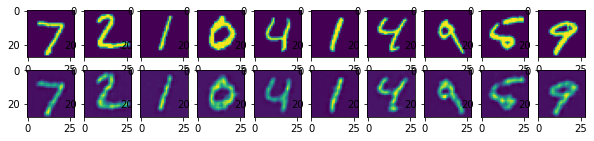

Epoch:  1
Total Loss: 64454.7578125


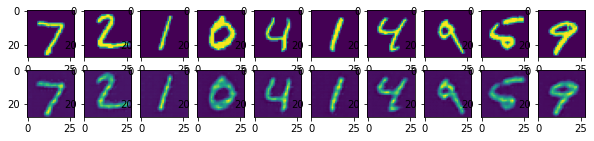

Epoch:  2
Total Loss: 66123.421875


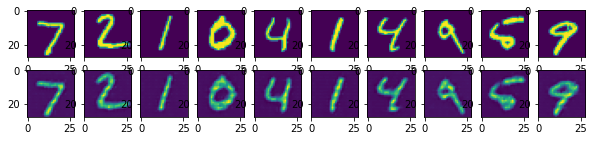

Epoch:  3
Total Loss: 40875.4765625


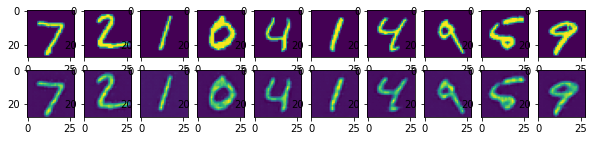

Epoch:  4
Total Loss: 33761.87109375


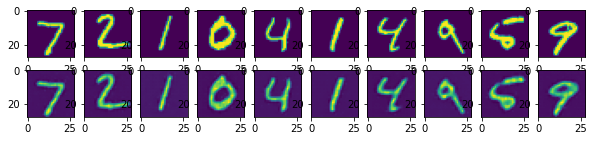

Showing autoencoder for noise function: <function random_scale at 0x7fd891946700>
Epoch:  0
Total Loss: 133325.078125


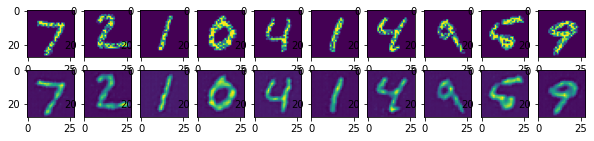

Epoch:  1
Total Loss: 138675.703125


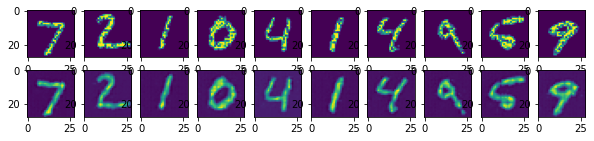

Epoch:  2
Total Loss: 118182.734375


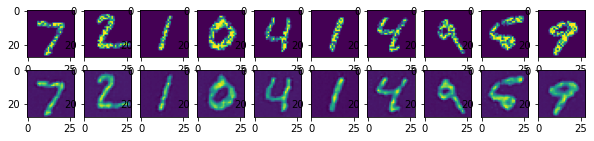

Epoch:  3
Total Loss: 116211.7421875


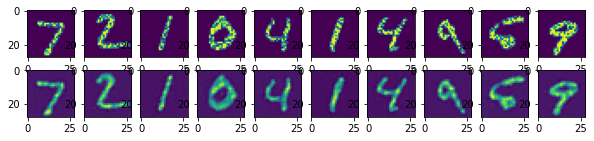

Epoch:  4
Total Loss: 115687.484375


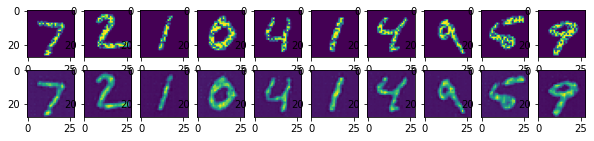

Showing autoencoder for noise function: <function random_noise at 0x7fd8919461f0>
Epoch:  0
Total Loss: 115563.71875


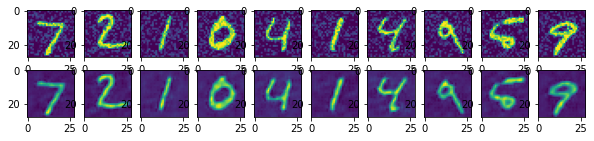

Epoch:  1
Total Loss: 109565.640625


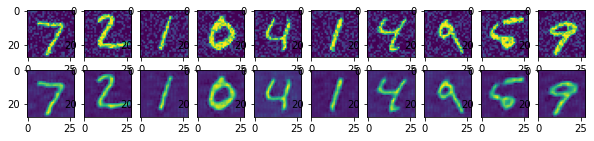

Epoch:  2
Total Loss: 106827.4375


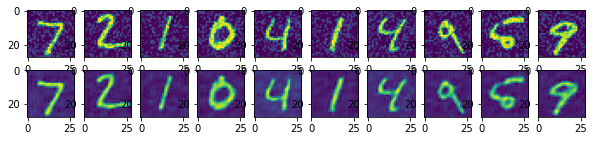

Epoch:  3
Total Loss: 105536.65625


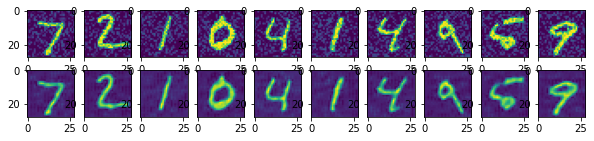

Epoch:  4
Total Loss: 103608.265625


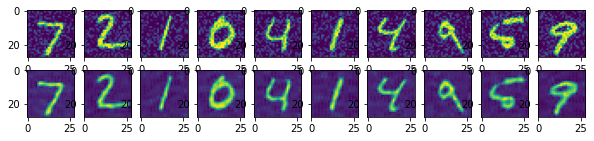

In [13]:
# This code is helper code to plot the mnist digits so you
# can see your autoencoder in action!
%matplotlib inline
import matplotlib.pyplot as plt

n_examples = 10
batch_size = 100
n_epochs = 5

mnist = tf.keras.datasets.mnist

(train_images, _),(test_images,_) = mnist.load_data()
test_images = test_images / 255
example_images = test_images[:n_examples]
train_images = train_images / 255

"""Test the convolutional autoencder using MNIST."""
def showImages(model, noise_function):  

  corrupted = tf.reshape(noise_function(example_images), [-1, 28, 28, 1])
  recon = model(corrupted)

  fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
  for example_i in range(n_examples):
      axs[0][example_i].imshow(
          np.reshape(
              np.reshape(corrupted[example_i, ...], (784,)),
              (28, 28)))
      axs[1][example_i].imshow(
          np.reshape(
              np.reshape(recon[example_i, ...], (784,)),
              (28, 28)))
  plt.show()

# Runs the autoencoder
# Run for each noise function
for noise_function in [no_noise, random_scale, random_noise]:
  print("Showing autoencoder for noise function: {0}".format(noise_function))
  model = AutoEncoder()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

  for i in range(n_epochs):
    for j in range(0, len(train_images), batch_size):
      train(model, optimizer, train_images[j:j+batch_size], noise_function)

    print("Epoch: ", i)
    sum_loss = total_loss(model, test_images, noise_function)
    print("Total Loss: {0}".format(sum_loss))
    showImages(model, noise_function)

## Checkpoint! 

Check to see if your denoiser works! If it works, you should see the autoencoder images remove noise from the original inputs. The top row for each epoch is the input image and the bottom is the autoencoded image. 

Check out how the different noise functions are handled by the autoencoder.

## Visualizing the Data Representation

We can now visualize where MNIST data points are positioned in the lower dimensional vector space created by the autoencoder (this is similar to the visualization in lecture). Run the following cell to view a 2 dimensional projection of this vector space, where each color represents a different MNIST digit. Notice how even though the dimensionality of this space is much lower than the original (160 vs 784), relevant information about the digits is preserved.

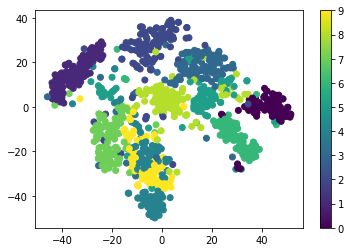

In [19]:
from sklearn.manifold import TSNE

NUM_SAMPLES = 1000

(_, _),(t_images,t_labels) = mnist.load_data()
t_images = t_images[:NUM_SAMPLES]
t_labels = t_labels[:NUM_SAMPLES]
t_images = t_images / 255

z = model.encoder(tf.reshape(random_noise(t_images), [-1, 28, 28, 1]))
z = np.reshape(z, [NUM_SAMPLES, -1])

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(z)
colors = t_labels
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors)
plt.colorbar()
plt.show()

## Finished part 1!
Give yourself a good pat on the back.. in part 2 we will take this model and apply it to a larger data set